## Ensemble methods: AdaBoost

Understand and visualise the boosting principle.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

In [2]:
# unit test utilities
def is_approximately_equal(test,target,eps=1e-2):
    return np.mean(np.fabs(np.array(test) - np.array(target)))<eps

def assert_test_equality(test, target):
    assert is_approximately_equal(test, target), 'Expected:\n %s \nbut got:\n %s'%(target, test)

Use the function `plot` to visualise the decision surface of a predictor (a single weak predictor or a strong one) and mark the importance of instances if the information is available. 

In [3]:
def plot(X, y, preds=None, instance_weights=None, predict_func=None):
    cmap='bwr'
    if instance_weights is None:
        instance_weights = np.ones(X.shape[0])/X.shape[0]
    res = 20
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, res),np.linspace(y_min, y_max, res))
    if predict_func is None:
        Z = np.ones(xx.shape)*.5
    else:
        Z = predict_func(np.hstack([xx.reshape(-1,1), yy.reshape(-1,1)]))
        Z = Z.reshape(xx.shape)
    if np.mean(Z) != -1:
        plt.figure(figsize=(4,4))
        plt.contourf(xx, yy, Z, levels=20, cmap=cmap, alpha=.5)
        if preds is None:
            colors = 'w'
        else:
            colors = ['w' if status else 'k' for status in (y == preds)]
        scaled_instance_weights = instance_weights*X.shape[0] * 20
        plt.scatter(X[:,0],X[:,1], c=y, s=scaled_instance_weights, edgecolors=colors, cmap=cmap)
        plt.show()

## Question 1

Make a function `error(targets, preds, weights=None)` that computes the fraction of incorrect predictions with respect to the input targets. If the input array `weights` is avaialble then each error is weighted by the corresponding weight.

In [4]:
def error(targets, preds, weights=None):
    if(weights is not None):
        weighted_error = [weights[i] for i in range(len(preds)) if preds[i]!=targets[i]]
        error  = sum(weighted_error)
        return error
    else:
        unweighted_error = [1 for i in range(len(preds)) if preds[i]!=targets[i]]
        error  = sum(unweighted_error)
        return error

In [5]:
# This cell is reserved for the unit tests. Do not consider this cell. 
### BEGIN TESTS
test_target=np.array([1,-1])
test_preds=np.array([1,1])
test_weights=np.array([.1,.9])
e = error(test_target, test_preds, test_weights)
assert e==0.9, 'Calling error on the test data should yield 0.9 rather than %.2f'%e
### END TESTS

## Question 2

Write the function `Wm, alpha, error = update_weights(Wm, preds, targets)` that implements the adaboost strategy to compute the updated weights `Wm`, the importance score `alpha` and the error value `error`.

See the lecture notes for reference.

In [6]:
def update_weights(Wm, preds, targets):
    errors = error(targets,preds,Wm)
    numerator = 1-errors
    classifier_error = 0.5*np.log(numerator/errors)
    updated_weights=  []
    indicator = [1 if preds[i]!=targets[i] else 0 for i in range(len(targets))]
    for i in range(len(Wm)):
        exponent = np.round(np.exp(classifier_error*indicator[i]),2)
        updated_weights.append(np.round(Wm[i]*exponent,2))
    updated_weights = np.array([np.round(i/sum(updated_weights),2) for i in updated_weights])
    return updated_weights,classifier_error,errors



In [7]:
# This cell is reserved for the unit tests. Do not consider this cell. 
### BEGIN TESTS
test_Wm = np.array([0.1,0.2,0.5,0.2])
test_preds = np.array([1,-1,1,1])
test_targets = np.array([-1,1,1,1])
test_Wm, test_alpha, test_error = update_weights(test_Wm, test_preds, test_targets)
target_Wm = np.array([0.13, 0.26, 0.43, 0.17])
assert_test_equality(test_Wm, target_Wm)
target_alpha = 0.423
assert_test_equality(test_alpha, target_alpha)
target_error = 0.3
assert_test_equality(test_error, target_error)
### END TESTS

## Question 3

a) Make the function `Wm = initialise_weights(X)` to initialise the instance weights for the AdaBoost algorithm.

b) Study the following code for the function `train_adaboost(X_train, y_train, n_iter, max_depth=1, display=False)`. This will require your functions `initialise_weights` and `update_weights` to be correctly implemented.

In [8]:
def initialise_weights(X):
    N = len(X)
    weights = [1/N for i in range(N)]
    return weights

In [9]:
# This cell is reserved for the unit tests. Do not consider this cell. 
### BEGIN TESTS
test_X = np.array([[1,1],[-1,-1],[0.5,0.5],[-0.5,-0.5]])
test_Wm = initialise_weights(test_X)
target_Wm = np.array([0.25, 0.25, 0.25, 0.25])
assert_test_equality(test_Wm, target_Wm)
### END TESTS

In [10]:
from sklearn.tree import DecisionTreeClassifier

def train_adaboost(X_train, y_train, n_iter, max_depth=1, display=False):
    models = [] 
    errors = []
    alphas = []
    weights = []
    Wm = initialise_weights(X_train)
    for m in range(n_iter):
        """fint and predict using a weak classifier: a decision tree of depth=max_depth """
        clf = DecisionTreeClassifier(max_depth=max_depth).fit(X_train,y_train,sample_weight=Wm)
        preds = clf.predict(X_train)
        
        """update instances' weights based on predictive error"""
        Wm, alpha, e = update_weights(Wm, preds, y_train)
        
        models.append((alpha,clf))       #Store the trained model (clf) and its weight (alpha)

        if display and m<10: #display only the first 10 updates
            plot(X_train, y_train, preds=None, instance_weights=Wm, predict_func=clf.predict)

        """Log info for downstream analysis"""
        errors.append(e)          
        alphas.append(alpha)      
        weights.append(Wm.copy())
    return models, errors, alphas, weights

In [11]:
# This cell is reserved for the unit tests. Do not consider this cell. 
### BEGIN TESTS

test_X_train = np.array([[1,1],[-1,-1],[0.5,0.5],[-0.5,-0.5]])
test_y_train = np.array([1,-1,-1,1])
test_models, test_errors, test_alphas, test_weights = train_adaboost(test_X_train, test_y_train, n_iter=1, max_depth=1, display=False)

assert len(test_models) == 1 and len(test_models[0]) == 2, 'Expected one model-alpha pair only'
assert_test_equality(test_errors, [0.25])
assert_test_equality(test_alphas, [0.5493])
target_weights = np.array([0.21, 0.21, 0.36 , 0.21])
assert_test_equality(test_weights, target_weights)
### END TESTS

## Question 4

Make the function `X,y = make_data()` that loads the iris dataset from scikit [link](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) and transforms the data in the following way:
1. the data matrix will preserve only feature with id 0 and id 2, i.e. the data matrix will contain two dimensinal instances
2. the targets will be recoded as follows: 
- class 1 -> class 1
- class 0 -> class -1
- class 2 -> class -1

When plotting the data via `plot(X,y)` you should obtain something like:

<img src='plot.png' width=300>

In [12]:
from sklearn.datasets import load_iris
def make_data():
    X,y = load_iris(return_X_y=True)
    X = [[i[0],i[1]] for i in X]
    X = np.array(X)
    y = [-1 if (i==0 or i == 2) else i for i in y]
    y = np.array(y)
    return X,y

In [13]:
# This cell is reserved for the unit tests. Do not consider this cell. 
### BEGIN TESTS
X,y = make_data()
assert len(set(y)) == 2, 'Expecting 2 classes only'
assert X.shape[1] == 2, 'Expecting two dimensional data matrix'
assert np.sum(y == -1) == 100 and np.sum(y == 1) == 50, 'Expecting 50 positive and 100 negative instances'
### END TESTS

## Question 5

Before running the following cells, think about what you expect the result to be.

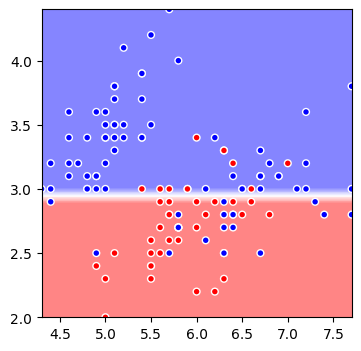

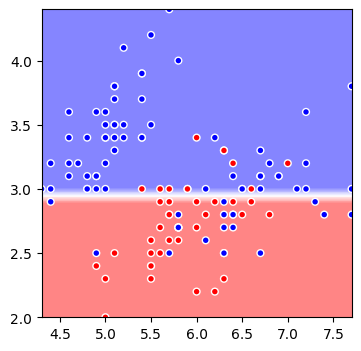

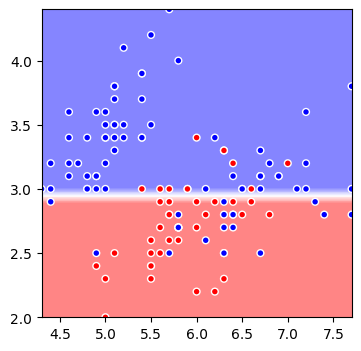

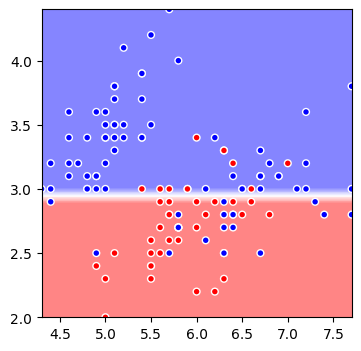

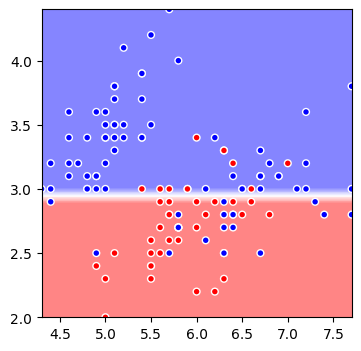

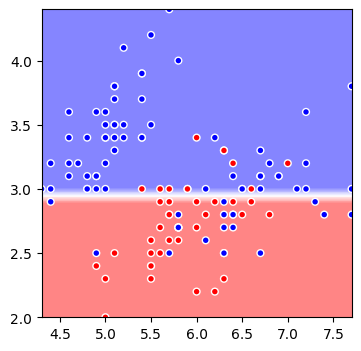

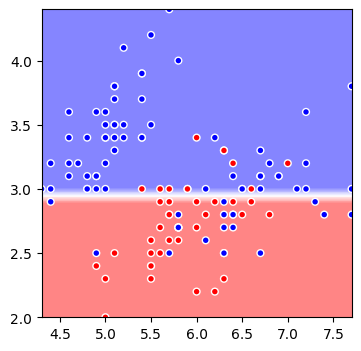

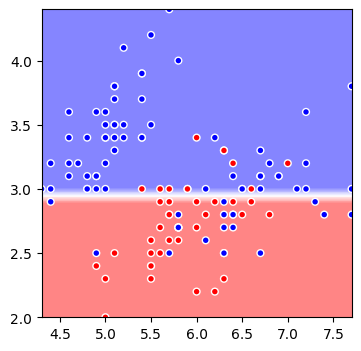

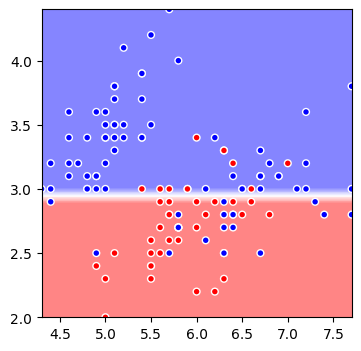

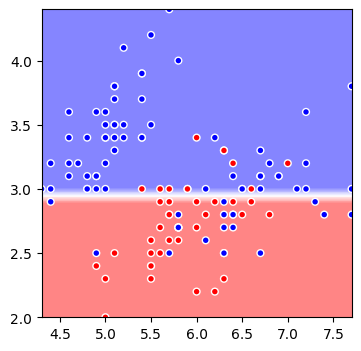

In [14]:
X,y = make_data()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)

models, errors, alphas, weights = train_adaboost(X_train, y_train, n_iter=100, max_depth=1, display=True)

## Question 6

Before running the following cells, think about what you expect the result to be.

Why do you get the behavior shown in the plots for the error and the alpha coefficient as the number of iterations increases?

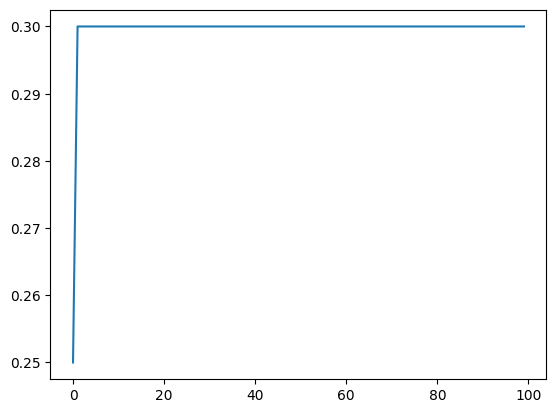

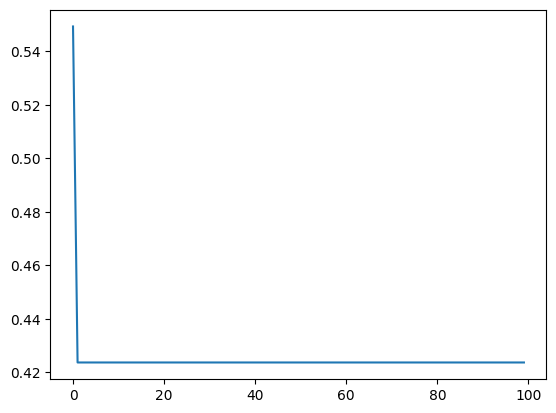

In [15]:
# what do you expect here?

plt.plot(errors)
plt.show()

plt.plot(alphas)
plt.show()

## Question 7

Before running the following cells, think about what you expect the result to be.

Which are the instances that will receive most weight? 

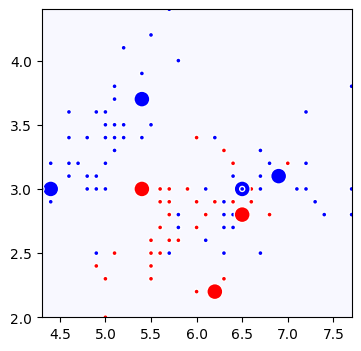

In [16]:
def plot_difficult_instances(X_train, y_train, W, top_k=20):
    idx = np.argsort(-W)[:top_k]
    Wb = np.ones(W.shape) 
    Wb[idx] = 10
    Wb = Wb / np.sum(Wb)
    plot(X_train, y_train, instance_weights=Wb)

W = weights[-1]
plot_difficult_instances(X_train, y_train, W, top_k=7)

## Question 8

a) Make the function `predict_adaboost(X_test, models)` that returns the predicted class array for a data matrix containing test instances, using the AdaBoost algorithm and the already fit models + alpha avaliable in `models`.

b) Make a function `score_adaboost(X_test, models)` that return the average predicted class (i.e. a real value between -1 and 1).

In [27]:
def predict_adaboost(X_test, models):
    predictions = []
    for j in range(len(X_test)):
        votes = []
        for i in models:
            alpha,clf = i
            prediction = clf.predict([X_test[j]])
            votes.append(prediction*alpha)
        sum_vote = sum(votes)
        if(sum_vote > 0):
            predictions.append(1)
        else:
            predictions.append(-1) 
    return predictions



        

def score_adaboost(X_test, models):
    predictions = []
    for j in range(len(X_test)):
        votes = []
        for i in models:
            alpha,clf = i
            prediction = clf.predict([X_test[j]])
            votes.append(prediction*alpha)
        votes = [i[0] for i in votes]
        sum_vote = sum(votes)
        predictions.append(sum_vote/len(votes))
    return predictions


In [28]:
# This cell is reserved for the unit tests. Do not consider this cell. 
### BEGIN TESTS

test_X_train = np.array([[1,1],[-1,-1],[0.5,0.5],[-0.5,-0.5]])
test_y_train = np.array([1,-1,-1,1])
test_models, test_errors, test_alphas, test_weights = train_adaboost(test_X_train, test_y_train, n_iter=1, max_depth=1, display=False)

eps=0.25
test_X_test = np.array([[1+eps,1],[-1+eps,-1],[0.5+eps,0.5],[-0.5+eps,-0.5]])
test_preds = predict_adaboost(test_X_test, test_models)
target_preds = np.array([ 1., -1.,  1.,  1.])
assert_test_equality(test_preds, target_preds)

test_scores = score_adaboost(test_X_test, test_models)
target_scores = np.array([ 0.54, -0.54,  0.54,  0.54])
assert_test_equality(test_scores, target_scores)
### END TESTS

## Question 9

Try the following code. 

```python
e = error(y_test, predict_adaboost(X_test, models))
print('Acc:%.3f  Err:%.3f'%(1-e,e))
plot(X_test, predict_adaboost(X_test, models), y_test)
```

You should obtain a result similar to:

<img src='plot2.png' width=300>

Acc:-8.000  Err:9.000


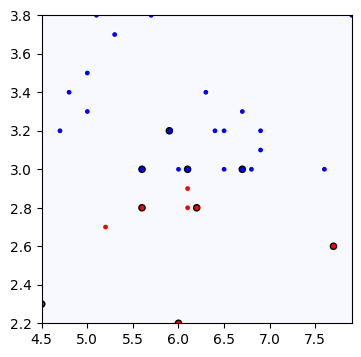

In [29]:
e = error(y_test, predict_adaboost(X_test, models))
print('Acc:%.3f  Err:%.3f'%(1-e,e))
plot(X_test, predict_adaboost(X_test, models), y_test)

## Bonus material

In the following cells you can find some code that allows you to play with an artificial classification problem and study the behavior of the AdaBoost algorithm. 

Try to change the max_depth parameter and discuss the results.

In [ ]:
# wrap the code to make a classifier object following the scikit style

class MyAdaBoostClassfier(object):
    def __init__(self, n_iter, max_depth=1):
        self.n_iter = n_iter
        self.max_depth=max_depth
        
    def fit(self, X_train, y_train):
        self.models, errors, alphas, weights = train_adaboost(X_train, y_train, n_iter=self.n_iter, max_depth=self.max_depth, display=False)
        return self
    
    def predict(self, X_test):
        return predict_adaboost(X_test, self.models)
        
    def decision_function(self, X_test):
        return score_adaboost(X_test, self.models)

In [ ]:
# prepare a classification data set
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.0, class_sep=1.0)
y[y==0]=-1
plot(X,y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)

In [ ]:
# Visualise the decision surface of the AdaBoostClassifier as implemented by scikit
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),n_estimators=100).fit(X_train, y_train)
e = error(y_test, clf.predict(X_test))
print('Acc:%.3f  Err:%.3f'%(1-e,e))
plot(X_test, y_test, preds=clf.predict(X_test), predict_func=clf.decision_function)

In [ ]:
# compare it to your implementation
clf = MyAdaBoostClassfier(n_iter=100, max_depth=1).fit(X_train, y_train)
e = error(y_test, clf.predict(X_test))
print('Acc:%.3f  Err:%.3f'%(1-e,e))
plot(X_test, y_test, preds=clf.predict(X_test), predict_func=clf.decision_function)

In [ ]:
# analyse the behavior of the AdaBoost classifier as the number of weak learners increases  
for n_iter in [3,31,301]:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)
    clf = MyAdaBoostClassfier(n_iter=n_iter, max_depth=1).fit(X_train, y_train)
    e = error(y_test, clf.predict(X_test))
    print('Acc:%.3f  Err:%.3f'%(1-e,e))
    plot(X_test, y_test, preds=clf.predict(X_test), predict_func=clf.decision_function)

In [ ]:
# analyse the behavior of the AdaBoost classifier as the number of weak learners increases 
# but using more powerful base classifiers, i.e. decision trees with greater depth
for n_iter in [3,31,301]:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)
    clf = MyAdaBoostClassfier(n_iter=n_iter, max_depth=3).fit(X_train, y_train)
    e = error(y_test, clf.predict(X_test))
    print('Acc:%.3f  Err:%.3f'%(1-e,e))
    plot(X_test, y_test, preds=clf.predict(X_test), predict_func=clf.decision_function)